# Vector Representations of Words
- [Original paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [TensorFlow tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Motivation
Natural language processing systems traditionally treat words as discrete atomic symbols.
- Provide no useful information regarding the relationships that may exist between the individual symbols.
- Representing words as unique leads to data sparsity. Need more data in order to successfully train statistical models.

**Vector space models (VSMs)** represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other'). Words that appear in the same contexts share semantic meaning.  
Two categories: 
- **Count-based methods** (e.g. Latent Semantic Analysis) compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. 
- **Predictive models** directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

**Word2vec** is a particularly computationally-efficient predictive model for learning word embeddings from raw text.   
It comes in two flavors. 
- **The Continuous Bag-of-Words model (CBOW)** predicts target words (e.g. 'mat') from source context words ('the cat sits on the') which is useful for smaller datasets.
- **The Skip-Gram model** does the inverse and predicts source context-words from the target words which does better for larger datasets. 

We will focus on the skip-gram model in the rest of this tutorial.

## Scaling up with Noise-Contrastive training
Neural probabilistic language models are traditionally trained using the maximum likelihood (ML) principle.
\begin{align}
P(w_t | h) &= \text{softmax} (\text{score} (w_t, h)) \\
           &= \frac{\exp \{ \text{score} (w_t, h) \} }
             {\sum_\text{Word w' in Vocab} \exp \{ \text{score} (w', h) \} }
\end{align}

Maximizing its log-likelihood:
\begin{align}
 J_\text{ML} &= \log P(w_t | h) \\
  &= \text{score} (w_t, h) -
     \log \left( \sum_\text{Word w' in Vocab} \exp \{ \text{score} (w', h) \} \right).
\end{align}

This is very expensive in computation.

The CBOW and skip-gram models are instead trained **using a binary classification objective (logistic regression)** to discriminate the real target words $w_t$ from $k$ imaginary (noise) words $\tilde w$, in the same context. 

### CBOW model. 
Mathematically, the objective (for each example) is to maximize
$$
J_\text{NEG} = \log Q_\theta(D=1 |w_t, h) +
  k \mathop{\mathbb{E}}_{\tilde w \sim P_\text{noise}}
     \left[ \log Q_\theta(D = 0 |\tilde w, h) \right]
$$
where $Q_θ(D=1|w,h)$ is the binary logistic regression probability under the model of seeing the word $w$ in the context $h$ in the dataset $D$, calculated in terms of the learned embedding vectors $θ$. In practice, we can use Monte Carlo to approximate the expectation. This technique is called **negative sampling**. The updates it proposes approximate the updates of the softmax function in the limit. We will actually make use of the very similar **noise-contrastive estimation (NCE) loss**, for which TensorFlow has a handy helper function $tf.nn.nce_loss()$.

### The Skip-gram model
Given a sequence of training words $w1,w2,w3, . . . ,wT,$ the objective of the Skip-grammodel is to maximize the average
log probability
$$
\frac{1}{T} \sum_{t=1}^T \sum_{−c≤j≤c,j\neq 0} \log p(w_{t+j} |w_t)
$$
where c is the size of the training context (which can be a function of the center word $w_t$).

The basic Skip-gram formulation defines $p(w_{t+j}|w_t)$ using the softmax function:
$$
p(w_o|w_I) = \frac{\text{exp}({v'}_{w_o}^T v_{w_I})}{\sum_{w=1}^W\text{exp}({v'}_w^T v_{w_I})}
$$
where $v_w$ and $v'_w$ are the “input” and “output” vector representations of $w$, and $W$ is the number of words in the vocabulary. Similar to logistic regression $p(y=k|x)$, $v_{w_I}$ is the input $[x\;1]$ and ${v'}_{w_o}$ is the weight $[w_k\;b_k]$ related to a particular class k. Different to logistic regression, the model trains both the input $x$ and the weight $w_k$ and biase $b_k$ where $x$ is the embedding vector representing the word $w_I$. 

The negative sampling is
$$
\log \sigma({v′}_{w_O}^T v_{w_I})+\sum_{i=1}^k \mathbb{E}_{w_i\sim P_n(w)}
\left[\log \sigma(−{v′}_{w_i}^⊤ v_{w_I})\right]
$$
where $\sigma(x) = 1/(1 + exp(−x))$.

We can visualize the learned vectors by projecting them down to 2 dimensions using for instance something like the [t-SNE dimensionality reduction technique](http://lvdmaaten.github.io/tsne/).
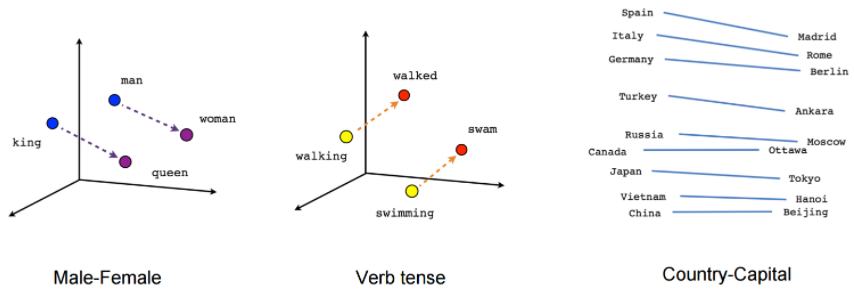